# 第10章 確率過程

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### 乱数シードの指定（テキスト掲載用）
拙著に掲載した標本路を再現するため，シードを明示しときます．本来は必要ないので，コメントアウトしてもよいです．

In [2]:
np.random.seed(321)

In [3]:
def SampleMean(Π):
    N = len(Π)
    if N == 0:
        return False #計算不可能
    else:
        return sum(Π)/len(Π)
    
def SampleVariance(Π):
    m=SampleMean(Π)  #標本平均
    return SampleMean( (Π-m*np.ones_like(Π))**2 )

def Cov(X,Y):
    mx = SampleMean(X)
    my = SampleMean(Y)
    return SampleMean(X*Y)-mx*my

## 10.4 モンテカルロ法による数値例

### パラメータと初期値

In [4]:
F = np.array([[0,0.5],[-0.8,0]])
G = np.array([[0.1,0],[0.1,0]])
Q = np.array([[1,0],[0,1]])
x0 = np.array([0.1,0])

### 10.4.1 標本路の数値計算

In [5]:
def SamplePaths(t_max, n_sample): #時間の刻み数，標本数
    tt = range(t_max+1)
    x1s = np.zeros((t_max+1, n_sample))
    x2s = np.zeros((t_max+1, n_sample))
    xx = x0.copy()
    for idx in range(n_sample):
        xx = x0
        for t in range(t_max+1):
            x1s[t,idx] = xx[0]
            x2s[t,idx] = xx[1]
            ww = np.random.randn(2) #2次元正規乱数（平均0，分散1）
            xx = F.dot(xx) + G.dot(ww)
    return tt, x1s, x2s

In [6]:
tt, x1s, x2s = SamplePaths(16,50)

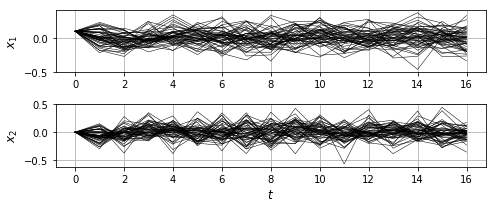

In [7]:
fig = plt.figure(figsize=(7, 3))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
for idx in range(50):
    ax1.plot(tt,x1s[:,idx],'k-',linewidth=0.5)
    ax2.plot(tt,x2s[:,idx],'k-',linewidth=0.5)

ax1.set_ylabel('$x_1$',fontsize=12)
ax2.set_ylabel('$x_2$',fontsize=12)
ax2.set_xlabel('$t$',fontsize=12)
ax1.grid()
ax2.grid()

fig.tight_layout()
plt.savefig('figs/Ch10-SamplePath.eps')

### 10.4.2 モンテカルロ法

In [8]:
def MonteCarlo(t_max, n_sample): #時間の刻み数，標本数
    xx = np.zeros_like(x0)
    tt = range(t_max+1)
    mm = np.zeros((t_max+1,5)) # m1, m2, s11, s12, s22 の時系列

    x1set = np.full(n_sample,x0[0])
    x2set = np.full(n_sample,x0[1])
    for t in range(t_max+1):
        mm[t,0] = SampleMean(x1set)
        mm[t,1] = SampleMean(x2set)
        mm[t,2] = SampleVariance(x1set)
        mm[t,3] = Cov(x1set,x2set)
        mm[t,4] = SampleVariance(x2set)
        for idx in range(n_sample):
            xx[0] = x1set[idx] 
            xx[1] = x2set[idx] 
            ww = np.random.randn(2) #2次元正規乱数（平均0，分散1）
            xx = F.dot(xx) + G.dot(ww)
            x1set[idx] = xx[0]  
            x2set[idx] = xx[1]  
    return tt, mm

In [9]:
start = time.time()

tt, mm_mc = MonteCarlo(16,50000)

T_monte = time.time() - start

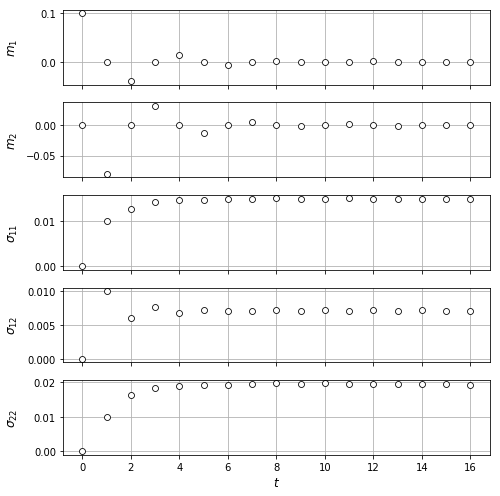

In [10]:
ylabels = ['$m_1$','$m_2$','$\sigma_{11}$','$\sigma_{12}$','$\sigma_{22}$']

fig = plt.figure(figsize=(7, 7))
for i in range(5):
    ax = fig.add_subplot(5,1,i+1)
    ax.plot(tt,mm_mc[:,i],'o', 
            markeredgecolor='k',
            markerfacecolor='w',
            markeredgewidth=0.8)
    ax.set_ylabel(ylabels[i],fontsize=12)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.grid()

    if i==4:
        ax.set_xlabel(r'$t$',fontsize=12)
        plt.setp(ax.get_xticklabels(),visible=True)
    else:
        plt.setp(ax.get_xticklabels(),visible=False)

fig.tight_layout()
plt.savefig('figs/Ch10-Monte.eps',bbox_inches='tight')

### 10.4.3 理論計算

In [11]:
def Theoretical(t_max): #時間の刻み数
    tt = range(t_max+1)
    mm = np.zeros((t_max+1,5)) # m1, m2, s11, s12, s22 の時系列

    mm[0,0] = x0[0]
    mm[0,1] = x0[1]
    mm[0,2] = (x0[0] - mm[0,0])**2
    mm[0,3] = (x0[0] - mm[0,0])*(x0[1] - mm[0,1])
    mm[0,4] = (x0[1] - mm[0,1])**2
    
    mean = np.array([mm[0,0],mm[0,1]])
    covmat = np.array([[mm[0,2],mm[0,3]],[mm[0,3],mm[0,4]]])
    for t in range(1,t_max+1):
        mean = F.dot(mean)
        covmat = F.dot(covmat.dot(F.T)) + G.dot(Q.dot(G.T))

        mm[t,0] = mean[0]
        mm[t,1] = mean[1]
        mm[t,2] = covmat[0,0]
        mm[t,3] = covmat[0,1]
        mm[t,4] = covmat[1,1]

    return tt, mm

In [12]:
start = time.time()

tt, mm_theory = Theoretical(16)

T_theor = time.time() - start

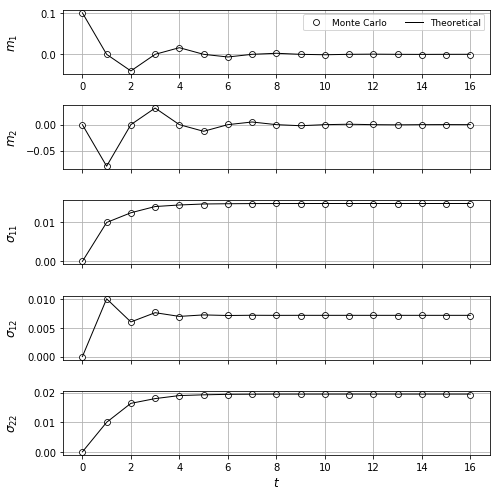

In [13]:
fig = plt.figure(figsize=(7, 7))
for i in range(5):
    ax = fig.add_subplot(5,1,i+1)
    ax.plot(tt,mm_mc[:,i],    'o',label='Monte Carlo',
            markeredgecolor='k',
            markerfacecolor='w',
            markeredgewidth=0.8)
    ax.plot(tt,mm_theory[:,i],'-',label='Theoretical',color='k',linewidth=1)
    ax.set_ylabel(ylabels[i],fontsize=12)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.grid()
    
    if i==0:
        fig.legend(bbox_to_anchor=(0.97,0.94), loc='right', ncol=3,fontsize=9)
    elif i==4:
        ax.set_xlabel(r'$t$',fontsize=12)
        plt.setp(ax.get_xticklabels(),visible=True)
    else:
        plt.setp(ax.get_xticklabels(),visible=False)

fig.tight_layout()
plt.savefig('figs/Ch10-MomResp.eps',bbox_inches='tight')

In [14]:
print( 'monte=%e  theor=%e  ratio=%f' % (T_monte, T_theor, T_monte / T_theor))

monte=3.202138e+00  theor=3.838539e-04  ratio=8342.075155


In [15]:
T_monte / T_theor

8342.075155279503